In [56]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
#change current working directory
%cd "/content/drive/MyDrive/1_dialog_act"

/content/drive/MyDrive/1_dialog_act


In [58]:
!pip install transformers
!pip install accelerate
#!pip install datasets
#!python3 -m spacy download en_core_web_lg

In [59]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig
from transformers import AdamW
from transformers import EarlyStoppingCallback, IntervalStrategy
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import recall_score, precision_score, f1_score
from torch import cuda
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import normalize
from itertools import product
import json
import shutil

import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
SAVE_PARAMETERS_TO = "./saved_parameters.json"
SAVE_MODEL_TO_PATH = "./saved_model/"
SAVE_MODEL_NAME = "dialogue_act_model"
TRAIN_DATA_SAVE_PATH = "utterances_act_types/train.json"
TEST_DATA_SAVE_PATH = "utterances_act_types/test.json"
VALID_DATA_SAVE_PATH = "utterances_act_types/valid.json"

ckpt_path = './checkpoint.pt'
best_model_path = './best_model.pt'

PRETRAINED_MODELS = {
    'bert': 'bert-large-uncased',
    'roberta': 'roberta-base',
    'xlnet': 'xlnet-large-cased',
    'xlm': 'xlm-mlm-en-2048',
    'distilbert': 'distilbert-base-uncased',
    'albert':'albert-base-v2'
}

MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'albert':(AlbertForSequenceClassification,AlbertTokenizer, AlbertConfig)
}

MODEL_TYPE = 'roberta'
PRETRAINED_MODEL_NAME = PRETRAINED_MODELS[MODEL_TYPE]

model_class, tokenizer_class, config_class = MODEL_CLASSES[MODEL_TYPE]

LEARNING_RATE = 1e-5
BATCH_SIZE = 32
EPOCHS = 10
WEIGHT_DECAY = 0.01

In [61]:
def save_variable_to_json(variable, file_path):
    with open(file_path, 'w') as file:
        json.dump(variable, file)

def load_variable_from_json(file_path):
    with open(file_path, 'r') as file:
        variable = json.load(file)
    return variable

In [62]:
try:
    X_train, y_train = load_variable_from_json(TRAIN_DATA_SAVE_PATH)
    X_test, y_test = load_variable_from_json(TEST_DATA_SAVE_PATH)
    X_valid, y_valid = load_variable_from_json(VALID_DATA_SAVE_PATH)

    print('Data loaded from file.')
except:
    print('No saved data found.')

Data loaded from file.


In [63]:
longest_train_data = max(X_train + X_test + X_valid, key=lambda x: len(x.split()))
print('Longest utterance length:', len(longest_train_data.split()))

num_labels = len(set([act for act_list in y_train for act in act_list ]))

all_labels = sorted(set([act for act_list in y_train for act in act_list ]))
print('Labels:', all_labels)


Longest utterance length: 119
Labels: ['Hotel-Inform', 'Hotel-Request', 'Restaurant-Inform', 'Restaurant-Request', 'general-bye', 'general-greet', 'general-thank', 'other']


In [64]:
# This will help us to transform the labels into a one-hot encoded numeric array
mlb = MultiLabelBinarizer(classes=list(all_labels))

In [65]:
# Load the pre-trained BERT model and tokenizer
tokenizer = tokenizer_class.from_pretrained(PRETRAINED_MODEL_NAME)

In [66]:
max_length = min(2 ** (len(tokenizer.tokenize(longest_train_data))-1).bit_length(), 512)
print('Max chosen length:', max_length)


Max chosen length: 256


In [67]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, X, y, max_length):
        self.X = X
        self.tokenizer = tokenizer
        self.max_length = max_length
        # Fit the label binarizer and transform the labels into one-hot encoded format
        self.labels = mlb.fit_transform(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Encode the utterance using the provided tokenizer
        encoding = self.tokenizer.encode_plus(
            self.X[idx],
            add_special_tokens=True,
            max_length = self.max_length,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            truncation=False,
            return_tensors='pt'
        )
        # Convert the list of strings into a one-hot encoded format
        label = self.labels[idx]  # This should now be a binary vector instead of a list of strings
        # Return the encoding and the label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float),
            'token_type_ids': encoding['token_type_ids'].flatten()
        }

In [68]:
# Smaller dataset to try
p = 1
n_train_samples = int(len(X_train) * p)
n_test_samples = int(len(X_test) * p)
n_valid_samples = int(len(X_valid) * p)

print("Train samples: ", n_train_samples)
print("Test samples: ", n_test_samples)
print("Valid samples: ", n_valid_samples)

Train samples:  56776
Test samples:  7372
Valid samples:  7374


In [69]:
train_dataset = CustomDataset(tokenizer, X_train[:n_train_samples], y_train[:n_train_samples], max_length)
test_dataset = CustomDataset(tokenizer, X_test[:n_test_samples], y_test[:n_test_samples], max_length)
valid_dataset = CustomDataset(tokenizer, X_valid[:n_valid_samples], y_valid[:n_valid_samples], max_length)

## Evaluation

In [70]:
train_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [71]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [72]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)


In [73]:
class BERTClass(torch.nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(BERTClass, self).__init__()
        self.num_labels = num_labels
        self.l1 = model_class.from_pretrained(pretrained_model_name, num_labels=self.num_labels)
        self.pre_classifier = torch.nn.Linear(8, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, self.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = output.view(-1, self.num_labels)  # Reshape the output
        return output

model = BERTClass(PRETRAINED_MODEL_NAME, num_labels)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, correct_bias=False)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [75]:
val_targets = []
val_outputs = []

In [76]:
def train_model(num_epochs, train_dataloader, valid_dataloader, model, optimizer, checkpoint_path, best_model_path):
    valid_loss_min = np.Inf


    for epoch in range(1, num_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()

        batch_idx = 0
        print("#################### Epoch {}: Training Start    ####################".format(epoch))

        for batch in tqdm(train_dataloader):
            input_ids = batch['input_ids'].to(device, dtype=torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.float)
            outputs = model(input_ids, attention_mask, token_type_ids)

            optimizer.zero_grad()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            #train_loss += loss.item() * input_ids.size(0)
            train_loss += ((1/ (batch_idx + 1)) * (loss.data - train_loss))
            batch_idx += 1

        print()
        print("#################### Epoch {}: Validation Start ####################".format(epoch))

        model.eval()

        with torch.no_grad():
            batch_idx = 0
            for batch in tqdm(valid_dataloader):
                input_ids = batch['input_ids'].to(device, dtype=torch.long)
                attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
                token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
                labels = batch['labels'].to(device, dtype=torch.float)
                outputs = model(input_ids, attention_mask, token_type_ids)

                loss = loss_fn(outputs, labels)
                #valid_loss += loss.item() * input_ids.size(0)
                valid_loss += ((1/ (batch_idx + 1)) * (loss.data - valid_loss))
                batch_idx += 1

                val_targets.extend(labels.cpu().detach().numpy().tolist())
                val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        train_loss = train_loss/len(train_dataloader.dataset)
        valid_loss = valid_loss/len(valid_dataloader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))

            checkpoint = {
                        'epoch': epoch,
                        'valid_loss_min': valid_loss,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict()
                    }

            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = valid_loss
        print()
    print("#################### Training finished     ####################")
    return model


In [78]:
try:
  trained_model, trained_optimizer, epoch, valid_loss_min = load_ckp(best_model_path, model, optimizer)
except:
  trained_model = train_model(EPOCHS, train_dataloader, valid_dataloader, model, optimizer, ckpt_path, best_model_path)


In [79]:
def validation(model, test_dataloader):
    model.eval()
    fin_targets = []
    fin_outputs = []
    softmax = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids = batch['input_ids'].to(device, dtype=torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.float)
            outputs = model(input_ids.squeeze(), attention_mask.squeeze(), token_type_ids.squeeze())
            fin_targets.extend(torch.argmax(softmax(labels), dim=1).cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.argmax(softmax(outputs), dim=1).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [80]:
predictions, test_labels = validation(trained_model, test_dataloader)

100%|██████████| 231/231 [01:44<00:00,  2.22it/s]


In [81]:
print('Accuracy:', accuracy_score(test_labels, predictions))
print('Precision:', precision_score(test_labels, predictions, average='weighted'))
print('Recall:', recall_score(test_labels, predictions, average='weighted'))
print('F1:', f1_score(test_labels, predictions, average='weighted'))

report = classification_report(test_labels, predictions, target_names=mlb.classes_)
print(report)

Accuracy: 0.9747693977211069
Precision: 0.9747643638297103
Recall: 0.9747693977211069
F1: 0.9745628499218375
                    precision    recall  f1-score   support

      Hotel-Inform       0.99      0.97      0.98      1328
     Hotel-Request       0.88      0.92      0.90       199
 Restaurant-Inform       0.98      0.94      0.96      1302
Restaurant-Request       0.80      0.90      0.85       188
       general-bye       0.99      1.00      1.00       293
     general-greet       0.00      0.00      0.00         6
     general-thank       1.00      1.00      1.00       940
             other       0.98      0.99      0.99      3116

          accuracy                           0.97      7372
         macro avg       0.83      0.84      0.83      7372
      weighted avg       0.97      0.97      0.97      7372



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

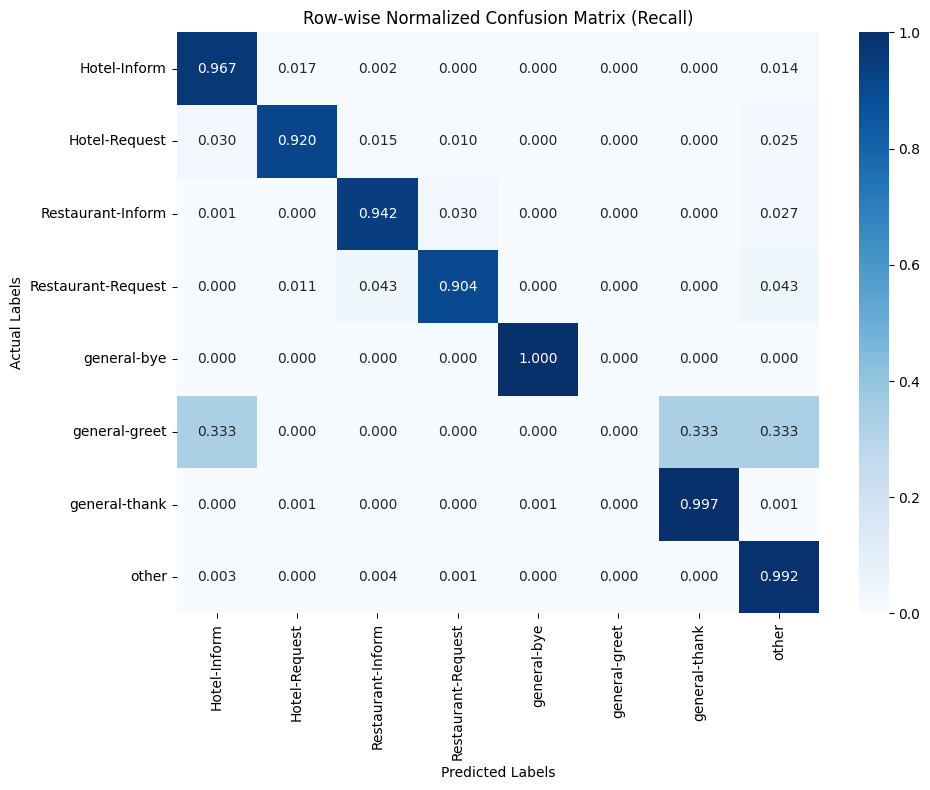

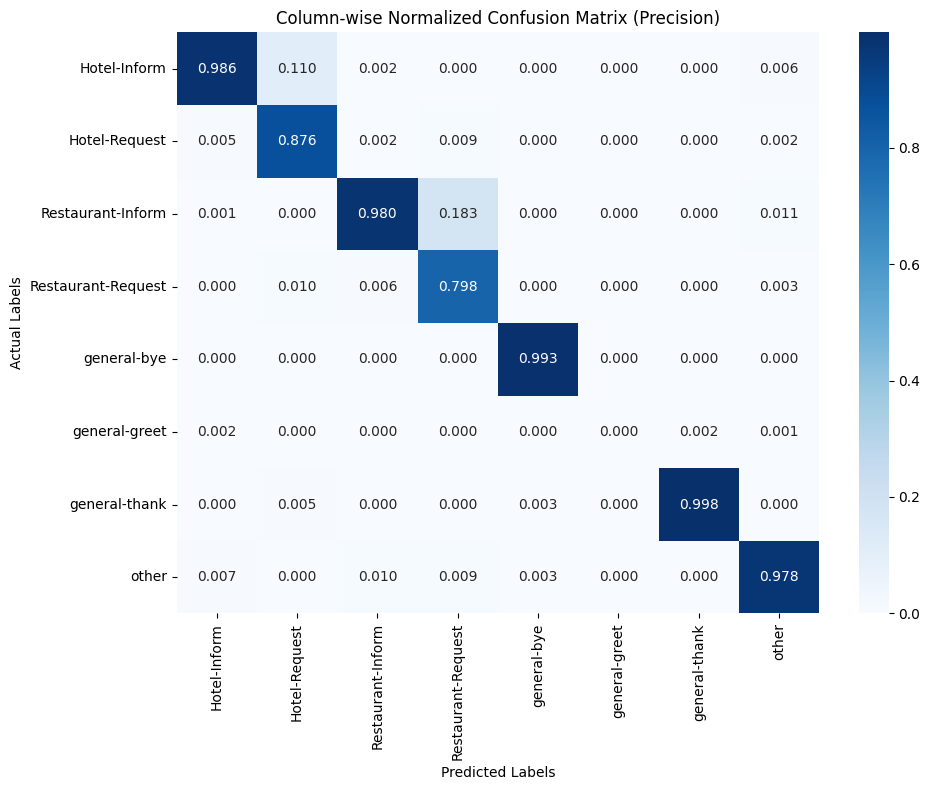

In [82]:
# Compute the confusion matrix
confusion = confusion_matrix(test_labels, predictions)

# Normalize by row sums (recall)
confusion_row_norm = normalize(confusion, norm='l1', axis=1)

# Normalize by column sums (precision)
confusion_col_norm = normalize(confusion, norm='l1', axis=0)

# Plotting the row-wise normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_row_norm, annot=True, cmap="Blues", fmt=".3f", xticklabels=all_labels, yticklabels=all_labels)
plt.title('Row-wise Normalized Confusion Matrix (Recall)')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.savefig('confusion_recall_mlp.png')
plt.show()

# Plotting the column-wise normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_col_norm, annot=True, cmap="Blues", fmt=".3f", xticklabels=all_labels, yticklabels=all_labels)
plt.title('Column-wise Normalized Confusion Matrix (Precision)')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.savefig('confusion_precision_mlp.png')
plt.show()